In [1]:
from pathlib import Path
import time

from tqdm import tqdm

from src.pipeline import img_pipeline
from src.detection import RoboflowDetector
from src.segmentation import SAMSegmenter, FastSAMSegmenter

ModelDependencyMissing: Your `inference` configuration does not support SAM model. Use pip install 'inference[sam]' to install missing requirements.To suppress this warning, set CORE_MODEL_SAM_ENABLED to False.
ModelDependencyMissing: Your `inference` configuration does not support SAM2 model. Use pip install 'inference[sam]' to install missing requirements.To suppress this warning, set CORE_MODEL_SAM2_ENABLED to False.
ModelDependencyMissing: Your `inference` configuration does not support SAM3 model. Install SAM3 dependencies and set CORE_MODEL_SAM3_ENABLED to True.
ModelDependencyMissing: Your `inference` configuration does not support SAM model. Use pip install 'inference[sam]' to install missing requirements.To suppress this warning, set CORE_MODEL_SAM_ENABLED to False.
ModelDependencyMissing: Your `inference` configuration does not support SAM2 model. Use pip install 'inference[sam]' to install missing requirements.To suppress this warning, set CORE_MODEL_SAM2_ENABLED to False.
M

In [8]:
# from yolo11seg.src.segmentation import FastSAMSegmenter

ROBOFLOW_API_KEY = "KDf14v839AjRzJXanN4h"
ROBOFLOW_MODEL_ID = "raspberrypi_redball/2"
SAM_MODEL_NAME = "sam2.1_b.pt"

detector = RoboflowDetector(model_id=ROBOFLOW_MODEL_ID, api_key=ROBOFLOW_API_KEY)
segmenter = SAMSegmenter()

In [ ]:
imgs_path = Path("balls")
DET_OUTPUT = Path("detection_output_folder")
SEG_OUTPUT = Path("seg_output_folder")
TEXT_OUTPUT = Path("txt_output_folder")
assert imgs_path.exists(), f"Folder '{imgs_path}' not found"
img_paths = list(imgs_path.glob("*"))

In [ ]:
start_time = time.time()

for img_path in tqdm(img_paths):
    img_pipeline(
        img_path,
        detect_fn=detector.detect,
        segment_fn=segmenter.segment_bbox, # Use segment_bbox for mode="bbox"
        det_output_dir=DET_OUTPUT,
        seg_output_dir=SEG_OUTPUT,
        txt_output_dir=TEXT_OUTPUT,
        mode="bbox"
    )

duration = time.time() - start_time
print(f"Done in {duration:.2f}s ({duration / len(img_paths):.2f}s/img)")

## Test YOLO avec prompt textuel

Tester YOLO pour détecter des objets avec un prompt en langage naturel

In [3]:
from src.detection import YOLODetector
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Initialiser le détecteur YOLO
yolo_detector = YOLODetector("yolo11n.pt", conf=0.25)

def test_yolo_with_prompt(image_path, prompt=None):
    """
    Test YOLO avec un prompt textuel
    
    Args:
        image_path: Chemin vers l'image
        prompt: Prompt textuel (ex: "person", "ball", "car")
    """
    # Charger l'image
    img = Image.open(image_path)
    
    # Détecter avec prompt
    if prompt:
        detections = yolo_detector.detect_all(image_path, prompt=prompt)
        title = f"Détections YOLO - Prompt: '{prompt}'"
    else:
        bbox = yolo_detector.detect(image_path)
        detections = [bbox] if bbox else []
        title = "Détections YOLO - Toutes classes"
    
    # Visualiser
    fig, ax = plt.subplots(1, 1, figsize=(10, 8))
    ax.imshow(img)
    ax.set_title(title)
    
    # Dessiner les bounding boxes
    for bbox in detections:
        x1, y1, x2, y2 = bbox
        rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, 
                                  linewidth=2, edgecolor='red', facecolor='none')
        ax.add_patch(rect)
    
    ax.axis('off')
    plt.tight_layout()
    plt.show()
    
    print(f"Nombre de détections: {len(detections)}")
    return detections

# Exemples d'utilisation:
# test_yolo_with_prompt("balls/image.jpg")  # Toutes les classes
# test_yolo_with_prompt("balls/image.jpg", prompt="ball")  # Seulement les ballons
# test_yolo_with_prompt("balls/image.jpg", prompt="person")  # Seulement les personnes

Test sur: validbin.jpg


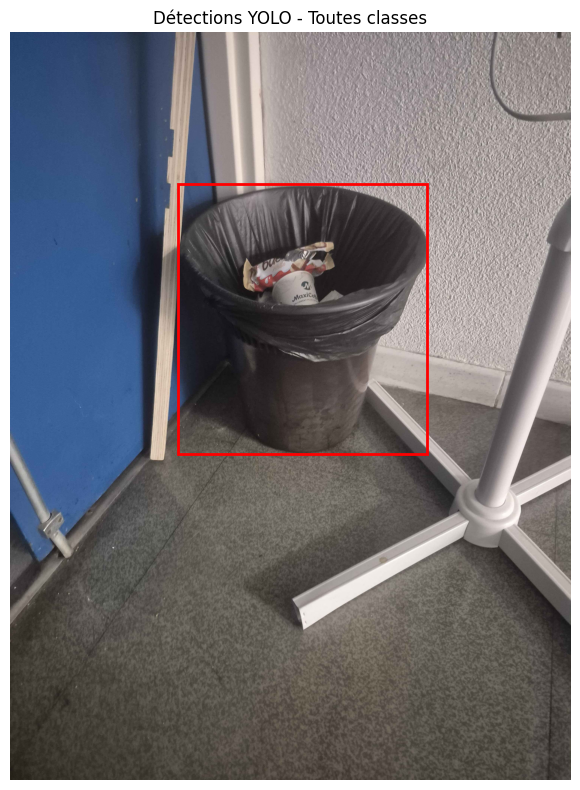

Nombre de détections: 1


[[900.6671752929688, 810.626953125, 2230.537109375, 2255.56884765625]]

In [5]:
# Test sur une image du dossier balls
test_img = Path("df") / "validbin.jpg"
print(f"Test sur: {test_img.name}")
test_yolo_with_prompt(test_img)

In [9]:
(tmp_dir := Path("tmp_dir")).mkdir(exist_ok=True)
img_pipeline(
        Path("df") / "validbin.jpg",
        detect_fn=yolo_detector.detect,
        segment_fn=segmenter.segment_bbox, # Use segment_bbox for mode="bbox"
        det_output_dir=tmp_dir,
        seg_output_dir=tmp_dir,
        mode="bbox"
    )